Pedro Jorge Oliveira Câmara - DRE: 120182069

As partes teóricas estão no outro pdf!

## Imports

In [493]:
using LinearAlgebra
using Plots
using GaussQuadrature
using SparseArrays
using DataFrames

## Trabalho 1

### Definições

In [494]:
# definições das constantes utilizadas
α = 1
β = 1
γ = 1

x_min = 0
x_max = 1


# definição das funções u, f
function u(x)
    return sin(π*x)
end


function f(x)
    return (α*π^2 + β)*sin(π*x) + γ*π*cos(π*x)
end

f (generic function with 2 methods)

### Galerkin e Matriz-Vetor

#### Definições de $\varphi$ e $\frac{d \varphi}{d \xi}$

In [495]:
function φ(ξ, a)
    if a == 1
        return (1-ξ) / 2
    elseif a == 2
        return (1+ξ) / 2
    end

    return nothing
end


function dφ(ξ, a)
    if a == 1
        return -1/2
    elseif a == 2
        return 1/2
    end

    return nothing
end


dφ (generic function with 1 method)

#### Montagem da matriz e do vetor locais

Cálculo da matriz local $K^e$ via quadratura gaussiana

In [496]:
function get_K_e(α, β, h)
    # A e B são as constantes da equação da K local via quadratura gaussiana
    # respectivamente as constantes do primeiro e segundo termo da equação
    A = 2*α/h
    B = β*h/2

    # dois pontos para a quadratura
    n_points = 2
    P, W = legendre(n_points)

    K_e = zeros(2, 2)

    for a = 1:2
        for b = 1:2
            for j = 1:n_points
                # operação diretamente da equação da K local
                K_e[a, b] += W[j] * (A*dφ(P[j], b)*dφ(P[j], a) + B*φ(P[j], b)*φ(P[j], a) + γ*dφ(P[j], b)*φ(P[j], a))
            end
        end
    end

    return K_e
end



get_K_e (generic function with 1 method)

Cálculo do vetor local $F^e$ via quadratura gaussiana

In [497]:
# faz o mapeamento da troca de variável de ξ para x
function x_from_ξ(ξ, h, x1e)
    return (ξ+1) * h/2 + x1e
end

function get_F_e(f_, h, x1e, P, W)
    F_e = zeros(2)

    for a = 1:2
        for j in 1:length(P)
            x = x_from_ξ(P[j], h, x1e)
            # operação diretamente da equação do F local
            F_e[a] +=  W[j] * f_(x) * φ(P[j], a) * h / 2
        end
    end

    return F_e
end

get_F_e (generic function with 2 methods)

#### Montagem da matriz e do vetor globais

Funções que calculam a matriz $LG$ e o vetor $EQ$

In [498]:
# monta a matriz LG pela sua definição
# [1 2 ... n_elements]
# [2 3 ... n_elements+1]
function get_LG(n_elements)
    return transpose(hcat(1:n_elements, 2:n_elements+1))
end


# monta o vetor EQ pela sua definição
# [m+1 1 2 ... m+1] com m = n_elements-1
function get_EQ(n_elements)
    m = n_elements-1
    EQ = vcat(m+1, 1:m, m+1)

    return m, EQ
end

get_EQ (generic function with 2 methods)

Cálculo da matriz $K$ global

In [499]:
function get_K(α, β, n_elements, m, EQoLG)
    h = 1/n_elements

    K = spzeros(m+1, m+1)
    K_e = get_K_e(α, β, h)

    for e = 1:n_elements
        for a = 1:2
            i = EQoLG[a, e]
            for b = 1:2
                j = EQoLG[b, e]
                K[i, j] += K_e[a, b]
            end
        end
    end

    return K[1:m, 1:m]
end


get_K (generic function with 1 method)

Cálculo do vetor $F$ global

In [500]:
function get_F(f_, n_elements, m, EQoLG)
    h = 1/n_elements
    F = zeros(m+1)

    n_points = 5
    P, W = legendre(n_points)

    for e = 1:n_elements
        F_e = get_F_e(f_, h, (e-1)*h, P, W)
        for a = 1:2
            i = EQoLG[a, e]
            F[i] += F_e[a]
        end
    end

    return F[1:m]
end


get_F (generic function with 2 methods)

#### Erro $L2$

In [501]:
function error_L2_norm(u, c, n_elements, EQoLG)
    h = 1/n_elements
    error = 0

    n_points = 5
    P, W = legendre(n_points)

    # aplica φ aos pontos de quadratura
    φ1P = φ.(P, 1)
    φ2P = φ.(P, 2)

    # calcula a equação do erro
    for e = 1:n_elements
        for j = 1:n_points
            x = x_from_ξ(P[j], h, (e-1)*h)
            error += W[j] * (u(x) - c[EQoLG[1,e]]*φ1P[j] - c[EQoLG[2, e]]*φ2P[j])^2
        end
    end

    return sqrt(h/2 * error)
end

error_L2_norm (generic function with 2 methods)

#### Resultados numéricos - Comparação

Utilizando $4$ elementos e $h = 1/4$

In [502]:
n_elements = 4
h = 1/n_elements

LG = get_LG(n_elements)
m, EQ = get_EQ(n_elements)
EQoLG = EQ[LG]

K = get_K(α, β, n_elements, m, EQoLG)
F = get_F(f, n_elements, m, EQoLG)

c = K \ F

3-element Vector{Float64}:
 0.7137289051760546
 1.0053005170657479
 0.7076694368382578

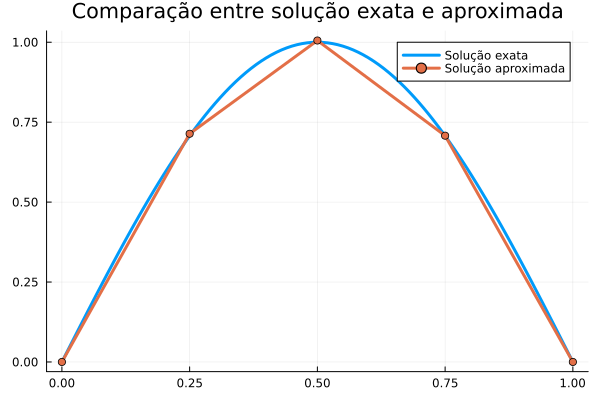

In [503]:
x = x_min:0.01:x_max
malha = x_min:h:x_max

plt = plot(x, u.(x), label="Solução exata", lw=3, title="Comparação entre solução exata e aproximada")
plot!(plt, malha, [0; c; 0], label="Solução aproximada", lw=3, linestyle=:solid, markershape=:circle)

In [504]:
K

3×3 SparseMatrixCSC{Float64, Int64} with 7 stored entries:
  8.16667  -3.45833    ⋅ 
 -4.45833   8.16667  -3.45833
   ⋅       -4.45833   8.16667

In [505]:
F

3-element Vector{Float64}:
 2.352121770752068
 2.5805560513947237
 1.2973355955943129

#### Resultados numéricos - Erro

Erro entre a solução aproximada e a solução exata

In [506]:
error_L2_norm(u, [c; 0], n_elements, EQoLG)

0.036236897255589685

Estudo da convergência do erro

In [507]:
function error_convergence()
    # lista com 2^2, 2^3, ..., 2^17
    vec_n_elements = [2^i for i = 2:17]
    # lista para guardar os erros de cada número de elementos de 2^2, 2^3, ..., 2^17
    vec_errors = zeros(length(vec_n_elements))

    # executa o método e guarda o erro associado para cada número de elementos
    for i = 1:length(vec_n_elements)
        n_elements = vec_n_elements[i]

        LG = get_LG(n_elements)
        m, EQ = get_EQ(n_elements)
        EQoLG = EQ[LG]

        K = get_K(n_elements, m, EQoLG)
        F = get_F(n_elements, m, EQoLG)

        c = K \ F

        vec_errors[i] = error_L2_norm([c; 0], n_elements, EQoLG)
    end

    vec_h = 1 ./ vec_n_elements

    display(DataFrame(h=vec_h, erro=vec_errors))

    plt = plot(vec_h, vec_errors, lw=3, linestyle=:solid, markershape=:circle, label="Erro", title="Estudo do erro no exemplo", xscale=:log10, yscale=:log10)
    plot!(plt, vec_h, vec_h.^2, lw=3, linestyle=:solid, label="h^2")
end

error_convergence (generic function with 2 methods)

In [508]:
# error_convergence()

## Equação do calor

In [509]:
function get_C_0!(C_0, u_0, n_elements, m, EQoLG, method)
  if method == 1
    h = 1/n_elements
    @. C_0 = u_0(h:h:1-h)
  elseif method == 2
    C_0 .= get_K(0.0, 1.0, n_elements, m, EQoLG) \ get_F(u_0, n_elements, m, EQoLG)
  end
end

get_C_0! (generic function with 1 method)

In [510]:
function get_C_n!(C_n, C_n_, A, B, n_elements, m, EQoLG, τ, n, f)
    t_medio = n*τ - τ/2
    F = get_F(x -> f(x, t_medio), n_elements, m, EQoLG)

    C_n .= A \ (B*C_n_ + τ*F)
end

get_C_n! (generic function with 2 methods)

τ

In [511]:
# definições das constantes utilizadas
α = 1
β = 1
γ = 1
T = 1 

x_min = 0
x_max = 1

# definição das funções u, f
function u(x, t)
    return sin(π*x) * (exp(-t) / π^2)
end

function u_0(x)
    return sin(π*x) / π^2 
end


function f(x, t)
    return sin(π*x) * ((-1 + α*π^2 + β) * exp(-t) / π^2)
end

f (generic function with 2 methods)

In [512]:
n_elements = 4
h = 1/n_elements

τ = h 
t = 0:τ:T
N = length(t) - 1

LG = get_LG(n_elements)
m, EQ = get_EQ(n_elements)
EQoLG = EQ[LG]

M = get_K(0.0, 1.0, n_elements, m, EQoLG)
K = get_K(α, β, n_elements, m, EQoLG)

A = M + (τ/2)*K 
B = M - (τ/2)*K 

C_n_ = zeros(m)
C_n = zeros(m)
method = 1

1

"Erros na norma L²:"

5-element Vector{Float64}:
 0.003980336614548407
 0.0034617491740433952
 0.002833379122091966
 0.0021751737675306908
 0.001581797936894704

"Erro máximo na norma L²:"

0.003980336614548407

┌ Info: Saved animation to /home/pedro/Desktop/Elementos-Finitos/solucao_exata_vs_aproximada.gif
└ @ Plots /home/pedro/.julia/packages/Plots/kLeqV/src/animation.jl:156


Plots.AnimatedGif("/home/pedro/Desktop/Elementos-Finitos/solucao_exata_vs_aproximada.gif")
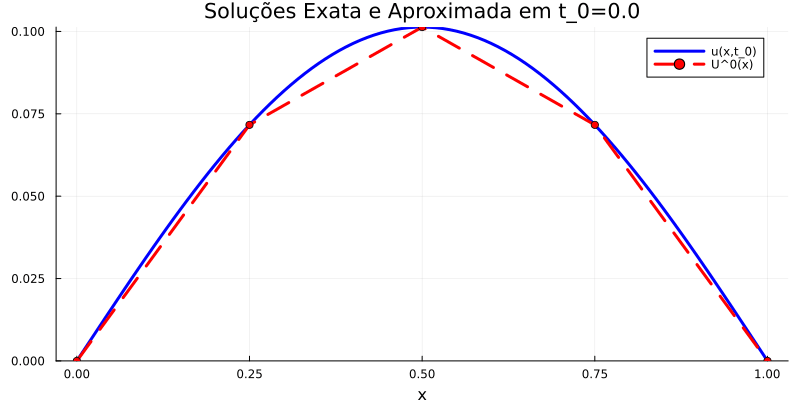

In [513]:
x = x_min:0.01:x_max
malha = x_min:h:x_max

y_list = [u(x, t) for x in x, t in t]
errors = zeros(N+1)

anim = @animate for n = 0:N
    # Calcula C⁰
    if n == 0
        get_C_0!(C_n_, u_0, n_elements, m, EQoLG, method)
        
    else
        # Calcula Cⁿ para n>0
        get_C_n!(C_n, C_n_, A, B, n_elements, m, EQoLG, τ, n, f)
        C_n_ .= C_n
    end

    # Calcula o erro na norma L²
    errors[n+1] = error_L2_norm(x -> u(x, t[n+1]), [C_n_; 0], n_elements, EQoLG)

    # Cria a figura com layout único
    plt = plot(size=(800, 400),
        title="Soluções Exata e Aproximada em t_$(n)=$(t[n+1])",
        xlabel="x",
        legend=:topright,
        ylim=(minimum(y_list), maximum(y_list)))

    # Gráfico da solução exata u(x, t[n+1])
    plot!(plt, x, u.(x, t[n+1]),
        lw=3, color=:blue, label="u(x,t_$(n))")

    # Gráfico da solução aproximada Uⁿ(x)
    plot!(plt, malha, [0; C_n_; 0],
        lw=3, color=:red, linestyle=:dash, markershape=:circle, label="U^$(n)(x)")
end

# Exibe o erro na norma L²
display("Erros na norma L²:")
display(errors)

# Exibe o erro máximo na norma L²
display("Erro máximo na norma L²:")
display(maximum(errors))

gif(anim, "solucao_exata_vs_aproximada.gif", fps=1)


In [514]:
function error_convergence(method)
    # lista com 2^2, 2^3, ..., 2^17
    vec_n_elements = [2^i for i = 2:11]
    # lista para guardar os erros de cada número de elementos de 2^2, 2^3, ..., 2^17
    vec_errors = zeros(length(vec_n_elements))

    vec_h = 1 ./ vec_n_elements 
    vec_τ = vec_h

    # executa o método e guarda o erro associado para cada número de elementos
    for i = 1:length(vec_n_elements)
        n_elements = vec_n_elements[i]
        h = vec_h[i] 
        τ = vec_τ[i]
        t = 0:τ:T
        N = length(t) - 1

        LG = get_LG(n_elements)
        m, EQ = get_EQ(n_elements)
        EQoLG = EQ[LG]

        M = get_K(0.0, 1.0, n_elements, m, EQoLG)
        K = get_K(α, β, n_elements, m, EQoLG)

        A = M + (τ/2)*K 
        B = M - (τ/2)*K 
        
        C_n_ = zeros(m)
        C_n = zeros(m)

        LU_A = lu(A)
        
        errors = zeros(N+1)

        get_C_0!(C_n_, u_0, n_elements, m, EQoLG, method)
        errors[1] = error_L2_norm(u_0, [C_n_; 0], n_elements, EQoLG)

        for n = 1:N  
        # Calcula Cⁿ para n>0
            get_C_n!(C_n, C_n_, LU_A, B, n_elements, m, EQoLG, τ, n, f)
            C_n_ .= C_n
            errors[n+1] = error_L2_norm(x -> u(x, t[n+1]), [C_n_; 0], n_elements, EQoLG)
        end

        vec_errors[i] = maximum(errors)
    end

    return vec_h, vec_errors
end


function display_errors(vec_h, vec_errors)
    plt = plot(
        vec_h, vec_errors, lw=3, linestyle=:solid, markershape=:circle,
        label="Erro", title="Estudo do erro",
        xscale=:log10, yscale=:log10, legend=:topleft
    )

    plot!(plt, vec_h, vec_h .^ 2, lw=3, linestyle=:solid, label="h²")

    xlabel!("h")
    ylabel!("Erro")

    display(plt)

    # Exibe a tabela com os valores de h e erro
    display("Tabela com os valores de h e erro")
    display(DataFrame(h=vec_h, erro=vec_errors))
end

display_errors (generic function with 1 method)

In [515]:
# vec_h, vec_errors = error_convergence(1)
# display_errors(vec_h, vec_errors)

In [516]:
# vec_h, vec_errors = error_convergence(2)
# display_errors(vec_h, vec_errors)

## Trabalho 2 - Equação não linear 

#### Construção do vetor $G^e$ local e G global

In [517]:
function get_G_e(g, h, x1e, P, W, c1, c2)
    G_e = zeros(2)

    for a = 1:2
        for j in 1:length(P)
            x = x_from_ξ(P[j], h, x1e)
            #G_e[a] += W[j] * g(c1*φ(x, 1) + c2*φ(x, 2)) * φ(P[j], a) * h/2
            G_e[a] += W[j] * g(c1*φ(P[j], 1) + c2*φ(P[j], 2)) * φ(P[j], a) * h/2
        end
    end

    return G_e
end


function get_G(g, ne, m, EQoLG)
    h = 1/ne 
    G = zeros(m+1)
    P, W = legendre(5)

    for e = 1:ne 
        c1 = EQoLG[1, e]
        c2 = EQoLG[2, e]
        G_e = get_G_e(g, h, (e-1)*h, P, W, c1, c2)
        for a = 1:2
            i = EQoLG[a, e]
            G[i] += G_e[a]
        end 
    end

    return G[1:m]
end 

get_G (generic function with 1 method)

#### Definições das funções necessárias

In [518]:
function get_C_1!(C_0, C_1, A, B, n_elements, m, EQoLG, τ, n, f, g)
    t_medio = n*τ - τ/2
    F = get_F(x -> f(x, t_medio), n_elements, m, EQoLG)
    G = get_G(g, n_elements, m, EQoLG)
    
    # calculando o C_1 provisório
    C_1 .= A \ (B*C_0 - τ*G + τ*F)

    # calculando o C_1
    G = get_G(g, n_elements, m, EQoLG)
    C_1 .= A \ (B*C_0 - τ*G + τ*F)
end

get_C_1! (generic function with 1 method)

In [519]:
function get_C_n!(C_n_two, C_n_one, C_n, A, B, n_elements, m, EQoLG, τ, n, f, g)
    t_medio = n*τ - τ/2
    F = get_F(x -> f(x, t_medio), n_elements, m, EQoLG)
    G = get_G(g, n_elements, m, EQoLG)

    C_n .= A \ (B*C_n_one - τ*G - τ*F)
end

get_C_n! (generic function with 2 methods)

#### Exemplo 1

In [520]:
α = 1
β = 1
T = 1 

x_min = 0
x_max = 1

function g(s)
    return s^3 - 2*s
end 

function u_0(x)
    return sin(π*x)/π^2
end 


function f(x, t)
    return (-1+α*π^2+β)*sin(π*x)*exp(-t) / π^2 + g(sin(π*x)*exp(-t)/π^2)
end
    

function u(x, t)
    return (sin(π*x)*exp(-t)) / π^2
end

u (generic function with 2 methods)

In [521]:
n_elements = 4
h = 1/n_elements

τ = h
t = 0:τ:T
N = length(t) - 1

LG = get_LG(n_elements)
m, EQ = get_EQ(n_elements)
EQoLG = EQ[LG]

M = get_K(0.0, 1.0, n_elements, m, EQoLG)
K = get_K(α, β, n_elements, m, EQoLG)

A = M + (τ/2)*K 
B = M - (τ/2)*K 

C_n_two = zeros(m)
C_n_one = zeros(m)
C_n = zeros(m)
method = 1

1

"C_0"

3-element Vector{Float64}:
 0.07164489603134454
 0.10132118364233778
 0.07164489603134454

"C_1"

3-element Vector{Float64}:
 -0.11236085779563826
 -0.20528188715469584
 -1.377987377433037

"C_2"

3-element Vector{Float64}:
 -0.11236085779563826
 -0.20528188715469584
 -1.377987377433037

"C_3"

3-element Vector{Float64}:
 -0.17422705921891227
 -1.3073455147343072
 -1.3476328702719296

"C_4"

3-element Vector{Float64}:
 -1.0370634667088994
 -1.2233218967848951
 -1.3851552659083683

"Erros na norma L²:"

5-element Vector{Float64}:
 0.003980336614548407
 0.012354738208216465
 0.6242809694187968
 0.9020606968801593
 1.0237351787428353

"Erro máximo na norma L²:"

1.0237351787428353

┌ Info: Saved animation to /home/pedro/Desktop/Elementos-Finitos/solucao_exata_vs_aproximada.gif
└ @ Plots /home/pedro/.julia/packages/Plots/kLeqV/src/animation.jl:156


Plots.AnimatedGif("/home/pedro/Desktop/Elementos-Finitos/solucao_exata_vs_aproximada.gif")
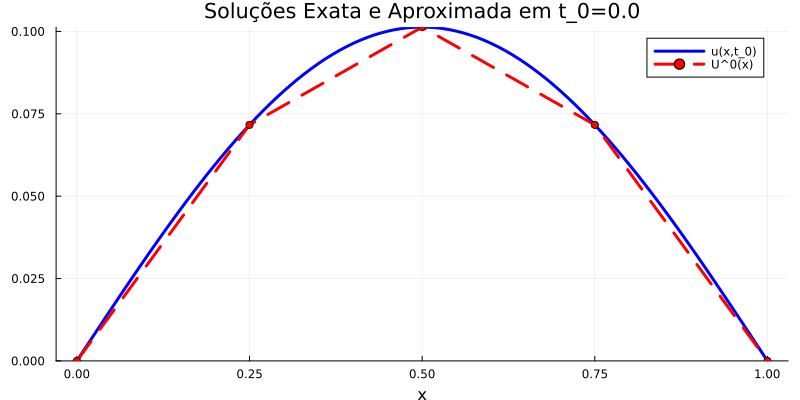

In [522]:
x = x_min:0.01:x_max
malha = x_min:h:x_max

y_list = [u(x, t) for x in x, t in t]
errors = zeros(N+1)

anim = @animate for n = 0:N
    # Calcula C⁰
    if n == 0
        get_C_0!(C_n_two, u_0, n_elements, m, EQoLG, method)
        C = C_n_two
    elseif n == 1 
        get_C_1!(C_n_two, C_n_one, A, B, n_elements, m, EQoLG, τ, n, f, g)
        C = C_n_one
    else
        # Calcula Cⁿ para n>=2
        get_C_n!(C_n_two, C_n_one, C_n, A, B, n_elements, m, EQoLG, τ, n, f, g)

        C_n_two .= C_n_one 
        C_n_one .= C_n

        C = C_n_two
    end

    # Calcula o erro na norma L²
    errors[n+1] = error_L2_norm(x -> u(x, t[n+1]), [C_n_two; 0], n_elements, EQoLG)

    # Cria a figura com layout único
    plt = plot(size=(800, 400),
        title="Soluções Exata e Aproximada em t_$(n)=$(t[n+1])",
        xlabel="x",
        legend=:topright,
        ylim=(minimum(y_list), maximum(y_list)))

    # Gráfico da solução exata u(x, t[n+1])
    plot!(plt, x, u.(x, t[n+1]),
        lw=3, color=:blue, label="u(x,t_$(n))")

    # Gráfico da solução aproximada Uⁿ(x)
    plot!(plt, malha, [0; C; 0],
        lw=3, color=:red, linestyle=:dash, markershape=:circle, label="U^$(n)(x)")

    display("C_$(n)")
    display(C)
end

# Exibe o erro na norma L²
display("Erros na norma L²:")
display(errors)

# Exibe o erro máximo na norma L²
display("Erro máximo na norma L²:")
display(maximum(errors))

gif(anim, "solucao_exata_vs_aproximada.gif", fps=1)

In [523]:
function error_convergence(method)
    # lista com 2^2, 2^3, ..., 2^17
    vec_n_elements = [2^i for i = 2:11]
    # lista para guardar os erros de cada número de elementos de 2^2, 2^3, ..., 2^17
    vec_errors = zeros(length(vec_n_elements))

    vec_h = 1 ./ vec_n_elements 
    vec_τ = vec_h

    # executa o método e guarda o erro associado para cada número de elementos
    for i = 1:length(vec_n_elements)
        n_elements = vec_n_elements[i]
        h = vec_h[i] 
        τ = vec_τ[i]
        t = 0:τ:T
        N = length(t) - 1

        LG = get_LG(n_elements)
        m, EQ = get_EQ(n_elements)
        EQoLG = EQ[LG]

        M = get_K(0.0, 1.0, n_elements, m, EQoLG)
        K = get_K(α, β, n_elements, m, EQoLG)

        A = M + (τ/2)*K 
        B = M - (τ/2)*K 
        
        C_n_two = zeros(m)
        C_n_one = zeros(m)
        C_n = zeros(m)

        LU_A = lu(A)
        
        errors = zeros(N+1)

        get_C_0!(C_n_two, u_0, n_elements, m, EQoLG, method)
        get_C_1!(C_n_two, C_n_one, A, B, n_elements, m, EQoLG, τ, 1, f, g)
        errors[1] = error_L2_norm(u_0, [C_n_two; 0], n_elements, EQoLG)
        errors[2] = error_L2_norm(u_0, [C_n_one; 0], n_elements, EQoLG)

        for n = 2:N  
        # Calcula Cⁿ para n>0
        get_C_n!(C_n_two, C_n_one, C_n, A, B, n_elements, m, EQoLG, τ, n, f, g)
            C_n_two .= C_n_one
            C_n_one .= C_n
            errors[n+1] = error_L2_norm(x -> u(x, t[n+1]), [C_n_one; 0], n_elements, EQoLG)
        end

        vec_errors[i] = maximum(errors)
    end

    return vec_h, vec_errors
end


function display_errors(vec_h, vec_errors)
    plt = plot(
        vec_h, vec_errors, lw=3, linestyle=:solid, markershape=:circle,
        label="Erro", title="Estudo do erro",
        xscale=:log10, yscale=:log10, legend=:topleft
    )

    plot!(plt, vec_h, vec_h .^ 2, lw=3, linestyle=:solid, label="h²")

    xlabel!("h")
    ylabel!("Erro")

    display(plt)

    # Exibe a tabela com os valores de h e erro
    display("Tabela com os valores de h e erro")
    display(DataFrame(h=vec_h, erro=vec_errors))
end

display_errors (generic function with 1 method)

In [524]:
# vec_h, vec_errors = error_convergence(1)
# display_errors(vec_h, vec_errors)

#### Exemplo 2

In [525]:
α = 1
β = 1
T = 1 

x_min = 0
x_max = 1

function g(s)
    return s^3 - 2*s
end 

function u_0(x)
    return sin(π*x)/π^2
end 


function f(x, t)
    return 0
end

f (generic function with 2 methods)

In [526]:
n_elements = 4
h = 1/n_elements

τ = h
t = 0:τ:T
N = length(t) - 1

LG = get_LG(n_elements)
m, EQ = get_EQ(n_elements)
EQoLG = EQ[LG]

M = get_K(0.0, 1.0, n_elements, m, EQoLG)
K = get_K(α, β, n_elements, m, EQoLG)

A = M + (τ/2)*K 
B = M - (τ/2)*K 

C_n_two = zeros(m)
C_n_one = zeros(m)
C_n = zeros(m)
method = 1

1

"C_0"

3-element Vector{Float64}:
 0.07164489603134454
 0.10132118364233778
 0.07164489603134454

"C_1"

3-element Vector{Float64}:
 -0.13293257375818723
 -0.25209879957888787
 -1.4429119577974523

"C_2"

3-element Vector{Float64}:
 -0.13293257375818723
 -0.25209879957888787
 -1.4429119577974523

"C_3"

3-element Vector{Float64}:
 -0.1781964793288587
 -1.3101302922823583
 -1.2878408908257737

"C_4"

3-element Vector{Float64}:
 -1.0284101576104026
 -1.1472679100807814
 -1.3482623329986414

┌ Info: Saved animation to /home/pedro/Desktop/Elementos-Finitos/solucao_exata_vs_aproximada.gif
└ @ Plots /home/pedro/.julia/packages/Plots/kLeqV/src/animation.jl:156


Plots.AnimatedGif("/home/pedro/Desktop/Elementos-Finitos/solucao_exata_vs_aproximada.gif")
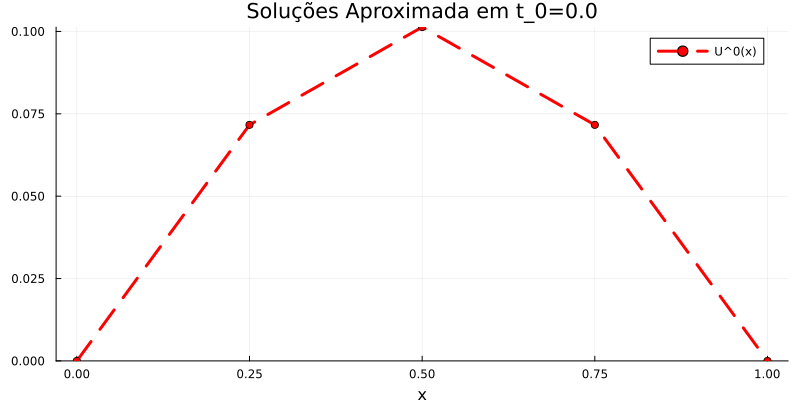

In [527]:
anim = @animate for n = 0:N
    # Calcula C⁰
    if n == 0
        get_C_0!(C_n_two, u_0, n_elements, m, EQoLG, method)
        C = C_n_two
    elseif n == 1 
        get_C_1!(C_n_two, C_n_one, A, B, n_elements, m, EQoLG, τ, n, f, g)
        C = C_n_one
    else
        # Calcula Cⁿ para n>=2
        get_C_n!(C_n_two, C_n_one, C_n, A, B, n_elements, m, EQoLG, τ, n, f, g)

        C_n_two .= C_n_one 
        C_n_one .= C_n

        C = C_n_two
    end

    # Cria a figura com layout único
    plt = plot(size=(800, 400),
        title="Soluções Aproximada em t_$(n)=$(t[n+1])",
        xlabel="x",
        legend=:topright,
        ylim=(minimum(y_list), maximum(y_list)))

    # Gráfico da solução aproximada Uⁿ(x)
    plot!(plt, malha, [0; C; 0],
        lw=3, color=:red, linestyle=:dash, markershape=:circle, label="U^$(n)(x)")

    display("C_$(n)")
    display(C)
end

gif(anim, "solucao_exata_vs_aproximada.gif", fps=1)

# Estacionário 2D

In [528]:
function x1_from_ξ(ξ_1, h_1, p_1)
    return (ξ_1 + 1)*(h_1/2) + p_1
end


function x2_from_ξ(ξ_2, h_2, p_2)
    return (ξ_2 + 1)*(h_2/2) + p_2
end


function φ(ξ, ƞ, a)
    if a == 1
        return (1/4)*(1-ξ)*(1-ƞ)

    elseif a == 2
        return (1/4)*(1+ξ)*(1-ƞ)

    elseif a == 3
        return (1/4)*(1+ξ)*(1+ƞ)

    elseif a == 4
        return (1/4)*(1-ξ)*(1+ƞ)

    end
end

φ (generic function with 2 methods)

In [529]:
function get_F_e(f, h1, h2, p1, p2, P, W)
    F_e = zeros(4)

    for a = 1:4
        for j = 1:length(P)
            for i = 1:length(P)
                x1 = x1_from_ξ(P[j], h1, p1)
                x2 = x2_from_ξ(P[i], h2, p2)

                F_e[a] += W[j] * W[i] * f(x1, x2) * φ(P[j], P[i], a)
            end
        end
    end

    F_e = F_e * (h1*h2)/4
    return F_e
end

get_F_e (generic function with 2 methods)

In [530]:
h1 = 1/4
h2 = 1/4
p1 = 0.0
p2 = 0.0

P, W = legendre(5)

function f(x1, x2)
    return 4/(h1*h2)
end

get_F_e(f, h1, h2, p1, p2, P, W)

4-element Vector{Float64}:
 0.9999999999999993
 0.9999999999999998
 1.0000000000000002
 0.9999999999999998

In [531]:
F_e = zeros(4)

function f(x1, x2)
    return 9*x1*x2 * 16/(h1*h2)^2
end

get_F_e(f, h1, h2, p1, p2, P, W)

4-element Vector{Float64}:
  3.9999999999999973
  7.999999999999998
 16.000000000000007
  7.999999999999999

In [532]:
function dφ_dξ(ξ, ƞ, a)
    if a == 1
        return (-1/4)*(1-ƞ)
    elseif a == 2
        return (1/4)*(1-ƞ)
    elseif a == 3
        return (1/4)*(1+ƞ)
    elseif a == 4
        return (-1/4)*(1+ƞ)
    end
end


function dφ_dƞ(ξ, ƞ, a)
    if a == 1
        return (-1/4)*(1-ξ)
    elseif a == 2
        return (-1/4)*(1+ξ)
    elseif a == 3
        return (1/4)*(1+ξ)
    elseif a == 4
        return (1/4)*(1-ξ)
    end
end

dφ_dƞ (generic function with 2 methods)

In [533]:
function get_K_e_(α, β, h1, h2, P, W)
    K_e = zeros(4, 4)

    for a = 1:4
        for b = 1:4
            for j = 1:length(P)
                for i = 1:length(P)
                # operação diretamente da equação da K local
                K_e[a, b] += (h2/h1)*α * W[j] * W[i] * dφ_dξ(P[j], P[i], b) * dφ_dξ(P[j],P[i], a)
                K_e[a, b] += (h2/h1)*α * W[j] * W[i] * dφ_dƞ(P[j], P[i], b) * dφ_dƞ(P[j], P[i], a)
                K_e[a, b] += (h1*h2/4)*β * W[j] * W[i] * φ(P[j], P[i], b) * φ(P[j], P[i], a)
                end
            end
        end
    end

    return K_e
end

get_K_e_ (generic function with 1 method)

In [534]:
h1 = 1/4
h2 = 1/4
α = 6.0
β = 0.0

P, W = legendre(2)

get_K_e_(α, β, h1, h2, P, W)

4×4 Matrix{Float64}:
  4.0  -1.0  -2.0  -1.0
 -1.0   4.0  -1.0  -2.0
 -2.0  -1.0   4.0  -1.0
 -1.0  -2.0  -1.0   4.0

In [535]:
α = 0.0
β = 9*4/(h1*h2)

get_K_e_(α, β, h1, h2, P, W)

4×4 Matrix{Float64}:
 4.0  2.0  1.0  2.0
 2.0  4.0  2.0  1.0
 1.0  2.0  4.0  2.0
 2.0  1.0  2.0  4.0

In [536]:
function get_LG(Nx1, Nx2)
    nx1 = Nx1 + 1
    nx2 = Nx2 + 1

    M = (1:nx1-1) .+ (0:nx1:(nx2-2)*nx1)'

    l = reshape(M, 1, :)

    LG = vcat(l, l .+ 1, l .+ (nx1+1), l.+ nx1)

    return LG
end

get_LG (generic function with 2 methods)

In [537]:
get_LG(4,3)

4×12 Matrix{Int64}:
 1  2  3   4   6   7   8   9  11  12  13  14
 2  3  4   5   7   8   9  10  12  13  14  15
 7  8  9  10  12  13  14  15  17  18  19  20
 6  7  8   9  11  12  13  14  16  17  18  19

In [538]:
get_LG(4,4)

4×16 Matrix{Int64}:
 1  2  3   4   6   7   8   9  11  12  13  14  16  17  18  19
 2  3  4   5   7   8   9  10  12  13  14  15  17  18  19  20
 7  8  9  10  12  13  14  15  17  18  19  20  22  23  24  25
 6  7  8   9  11  12  13  14  16  17  18  19  21  22  23  24

In [539]:
function get_EQ(Nx1, Nx2)
    nx1 = Nx1 + 1
    nx2 = Nx2 + 1
    m = (nx1-2) * (nx2-2)

    EQ = fill(m+1, nx1 * nx2)

    L = reshape( (0:nx1-3) .+ (nx1+2:nx1:(nx2-2)*nx1+2)' , :,1)

    EQ[L] = 1:m

    return m, EQ
end

get_EQ (generic function with 2 methods)

In [540]:
get_EQ(4,3)

(6, [7, 7, 7, 7, 7, 7, 1, 2, 3, 7, 7, 4, 5, 6, 7, 7, 7, 7, 7, 7])

In [541]:
get_EQ(4,4)

(9, [10, 10, 10, 10, 10, 10, 1, 2, 3, 10  …  10, 7, 8, 9, 10, 10, 10, 10, 10, 10])

In [542]:
function get_F(f, Nx1, Nx2, m, EQoLG)
    h1 = 1/Nx1
    h2 = 1/Nx2 
    ne = Nx1 * Nx2 

    P, W = legendre(5)

    F_e = zeros(4)
    F = zeros(m+1)
    
    for j = 1:Nx2
        p2 = (j-1)*h2
        for i = 1:Nx1
            p1 = (i-1)*h1 
            e = (j-1)*Nx1 + i 
            F_e = get_F_e(f, h1, h2, p1, p2, P, W)

            for a = 1:4
                F[EQoLG[a,e]] += F_e[a]
            end 
        end 
    end 

    return F[1:m]
end

get_F (generic function with 2 methods)

In [543]:
Nx1 = 4 
Nx2 = 3 
h1 = 1/Nx1 
h2 = 1/Nx2 

function f(x1, x2)
    return 4/(h1*h2)
end 

m, EQ = get_EQ(Nx1, Nx2)
LG = get_LG(Nx1, Nx2)
EQoLG = EQ[LG]

get_F(f, Nx1, Nx2, m, EQoLG)

6-element Vector{Float64}:
 3.9999999999999982
 3.9999999999999982
 3.9999999999999982
 3.9999999999999982
 3.9999999999999982
 3.9999999999999982

In [544]:
Nx1 = 4 
Nx2 = 4
h1 = 1/Nx1 
h2 = 1/Nx2 

function f(x1, x2)
    return (16*9*x1*x2)/((h1*h2)^2)
end 

m, EQ = get_EQ(Nx1, Nx2)
LG = get_LG(Nx1, Nx2)
EQoLG = EQ[LG]

get_F(f, Nx1, Nx2, m, EQoLG)

9-element Vector{Float64}:
  143.99999999999994
  287.9999999999999
  431.9999999999998
  287.9999999999999
  575.9999999999999
  863.9999999999995
  431.9999999999998
  863.9999999999997
 1295.9999999999998

In [545]:
function get_K_(α, β, Nx1, Nx2, m, EQoLG)
    h1 = 1/Nx1 
    h2 = 1/Nx2 
    ne = Nx1 * Nx2 

    P, W = legendre(2) 

    K_e = get_K_e_(α, β, h1, h2, P, W)
    K = spzeros(m+1, m+1)

    for e = 1:ne 
        for b = 1:4
            j = EQoLG[b, e]
            for a = 1:4
                i = EQoLG[a, e]
                K[i, j] += K_e[a, b]
            end
        end
    end

    return K[1:m, 1:m]
end

get_K_ (generic function with 1 method)

In [546]:
α = 1.0
β = 1.0
Nx1 = 4 
Nx2 = 3 

m, EQ = get_EQ(Nx1, Nx2)
LG = get_LG(Nx1, Nx2)
EQoLG = EQ[LG]

display(get_K_(α, β, Nx1, Nx2, m, EQoLG))

6×6 SparseMatrixCSC{Float64, Int64} with 28 stored entries:
  3.59259   -0.435185    ⋅        -0.435185  -0.44213     ⋅ 
 -0.435185   3.59259   -0.435185  -0.44213   -0.435185  -0.44213
   ⋅        -0.435185   3.59259     ⋅        -0.44213   -0.435185
 -0.435185  -0.44213     ⋅         3.59259   -0.435185    ⋅ 
 -0.44213   -0.435185  -0.44213   -0.435185   3.59259   -0.435185
   ⋅        -0.44213   -0.435185    ⋅        -0.435185   3.59259

In [547]:
function error_L2_norm(u, c, Nx1, Nx2, EQoLG)
    h1 = 1/Nx1 
    h2 = 1/Nx2 

    error = 0 

    P, W = legendre(5)

    for j = 1:Nx2 
        p2 = (j-1) * h2 
        for i = 1:Nx1 
            p1 = (i-1) * h1 
            e = (j-1)*Nx1 + i 

            c1e = c[EQoLG[1,e]]
            c2e = c[EQoLG[2,e]]
            c3e = c[EQoLG[3,e]]
            c4e = c[EQoLG[4,e]]

            for b = 1:5 
                ξ2 = P[b]
                x2 = x2_from_ξ(ξ2, h2, p2)
                for a = 1:5
                    ξ1 = P[a]
                    x1 = x1_from_ξ(ξ1, h1, p1)

                    error += W[a] * W[b] * (u(x1,x2) - 
                    c1e*ϕ(ξ1, ξ2, 1) - 
                    c2e*ϕ(ξ1, ξ2, 2) -
                    c3e*ϕ(ξ1, ξ2, 3) -
                    c4e*ϕ(ξ1, ξ2, 4))^2
                end
            end
        end
    end

    return sqrt(error * h1 * h2 / 4)
end

error_L2_norm (generic function with 2 methods)

# Estacionário 2D Quadrilátero

In [548]:
function φ(ξ, ƞ)
    return [(1/4)*(1-ξ)*(1-ƞ), (1/4)*(1+ξ)*(1-ƞ), (1/4)*(1+ξ)*(1+ƞ), (1/4)*(1-ξ)*(1+ƞ)]
end


function dφ_dξ(ξ, ƞ)
    return [(-1/4)*(1-ƞ), (1/4)*(1-ƞ), (1/4)*(1+ƞ), (-1/4)*(1+ƞ)]
end


function dφ_dƞ(ξ, ƞ)
    return [(-1/4)*(1-ξ), (-1/4)*(1+ξ), (1/4)*(1+ξ), (1/4)*(1-ξ)]
end

dφ_dƞ (generic function with 2 methods)

In [549]:
function get_F_e_quadrilatero(f, X1e, X2e, P, W)
    F_e = zeros(4)

    for i in 1:length(P)
        ξ1 = P[i]

        dφ_dƞ_vector = dφ_dƞ(ξ1, 1)

        for j in 1:length(P)
            ƞ = P[j]

            φ_vector = φ(ξ1, ƞ)
            dφ_dξ_vector = dφ_dξ(1, ƞ)

            x1 = dot(X1e, φ_vector)
            x2 = dot(X2e, φ_vector)

            det_J = dot(X1e, dφ_dξ_vector) * dot(X2e, dφ_dƞ_vector) - dot(X1e, dφ_dƞ_vector) * dot(X2e, dφ_dξ_vector)
            
            for a in 1:4
                F_e[a] += W[j] * W[i] * f(x1, x2) * φ_vector[a] * det_J
            end
        end
    end

    return F_e
end

get_F_e_quadrilatero (generic function with 1 method)

In [550]:
X1e = [0, 0.25, 0.25, 0]
X2e = [0, 0, 0.25, 0.25]

P, W = legendre(5)

function f(x1, x2)
    return 4/(0.25 * 0.25)
end

get_F_e_quadrilatero(f, X1e, X2e, P, W)

4-element Vector{Float64}:
 0.9999999999999993
 0.9999999999999998
 1.0000000000000002
 0.9999999999999998

In [551]:
X1e = [0, 0.25, 0.25, 0]
X2e = [0, 0, 0.25, 0.25]

P, W = legendre(5)

function f(x1, x2)
    return (16*9*x1*x2)/((0.25*0.25)^2)
end

get_F_e_quadrilatero(f, X1e, X2e, P, W)

4-element Vector{Float64}:
  3.9999999999999973
  7.999999999999998
 16.000000000000007
  7.999999999999999

In [552]:
X1e = [0, 2, 3, 1]
X2e = [0, 0, 1, 1]

P, W = legendre(5)

function f(x1, x2)
    return x1+x2
end

get_F_e_quadrilatero(f, X1e, X2e, P, W)

4-element Vector{Float64}:
 0.6666666666666662
 0.9999999999999998
 1.3333333333333337
 0.9999999999999998

In [553]:
function get_K_e_quadrilatero(α, β, X1e, X2e, P, W)
    K_e = zeros(4, 4)

    for i in 1:length(P)
        ξ = P[i]
        dφ_dƞ_vector = dφ_dƞ(ξ, 1)

        for j in 1:length(P)
            ƞ = P[j]

            φ_vector = φ(ξ, ƞ)
            dφ_dξ_vector = dφ_dξ(1, ƞ)

            dx1_dξ = dot(X1e, dφ_dξ_vector)
            dx2_dξ = dot(X2e, dφ_dξ_vector)

            dx1_dƞ = dot(X1e, dφ_dƞ_vector)
            dx2_dƞ = dot(X2e, dφ_dƞ_vector)

            det_J = dx1_dξ * dx2_dƞ - dx1_dƞ * dx2_dξ

            HᵀH₁₁ = dx2_dƞ^2 + dx1_dƞ^2
            HᵀH₁₂ = -dx1_dξ * dx1_dƞ - dx2_dξ * dx2_dƞ
            HᵀH₂₂ = dx2_dξ^2 + dx1_dξ^2

            for b in 1:4
                for a in 1:4
                    K_e[a, b] += W[j] * W[i] * (α/det_J) *
                    (dφ_dξ_vector[b] * (HᵀH₁₁ * dφ_dξ_vector[a] + HᵀH₁₂ * dφ_dƞ_vector[a]) +
                     dφ_dƞ_vector[b] * (HᵀH₁₂ * dφ_dξ_vector[a] + HᵀH₂₂ * dφ_dƞ_vector[a])) +
                     β * φ_vector[b] * φ_vector[a] * det_J
                end
            end
        end
    end

    return K_e
end

get_K_e_quadrilatero (generic function with 1 method)

In [554]:
α = 6
β = 0
X1e = [0, 0.25, 0.25, 0]
X2e = [0, 0, 0.25, 0.25]

P, W = legendre(2)

get_K_e_quadrilatero(α, β, X1e, X2e, P, W)

4×4 Matrix{Float64}:
  4.0  -1.0  -2.0  -1.0
 -1.0   4.0  -1.0  -2.0
 -2.0  -1.0   4.0  -1.0
 -1.0  -2.0  -1.0   4.0

In [555]:
α = 0.0
β = 576.0
X1e = [0, 0.25, 0.25, 0]
X2e = [0, 0, 0.25, 0.25]

P, W = legendre(2)

get_K_e_quadrilatero(α, β, X1e, X2e, P, W)

4×4 Matrix{Float64}:
 4.0  2.0  1.0  2.0
 2.0  4.0  2.0  1.0
 1.0  2.0  4.0  2.0
 2.0  1.0  2.0  4.0

In [556]:
α = 1.0
β = 1.0
X1e = [0, 2, 3, 1]
X2e = [0, 0, 1, 1]

P, W = legendre(2)

get_K_e_quadrilatero(α, β, X1e, X2e, P, W)

4×4 Matrix{Float64}:
  0.722222    0.111111   0.0555556  -0.388889
  0.111111    1.72222   -0.388889   -0.944444
  0.0555556  -0.388889   0.722222    0.111111
 -0.388889   -0.944444   0.111111    1.72222

In [557]:
function get_F_quadrilatero(f, X1, X2, m, EQ, LG)
    ne = size(LG, 2)

    P, W = legendre(5)

    F = zeros(m+1)
    for e in 1:ne 
        idx = LG[:, e]

        X1e = X1[idx]
        X2e = X2[idx]
        idx = EQ[idx]

        F_e = get_F_e_quadrilatero(f, X1e, X2e, P, W)

        for a in 1:4
            F[idx[a]] += F_e[a]
        end
    end
    
    return F[1:m]
end

get_F_quadrilatero (generic function with 1 method)

In [558]:
Nx1 = 4 
Nx2 = 3

m, EQ = get_EQ(Nx1, Nx2)
LG = get_LG(Nx1, Nx2)

h1 = 0.25 
h2 = 0.3333333333333333

X1 = [0.0   0.0       0.0       0.0
0.25  0.266168  0.275391  0.25
0.5   0.493792  0.521668  0.5
0.75  0.747176  0.708237  0.75
1.0   1.0       1.0       1.0]
X2 = [0.0   0.333333  0.666667  1.0
0.0   0.352246  0.633228  1.0
0.0   0.36139   0.693524  1.0
0.0   0.326172  0.689905  1.0
0.0   0.333333  0.666667  1.0]

function f(x1, x2)
    return x1+x2
end

get_F_quadrilatero(f, X1, X2, m, EQ, LG)

6-element Vector{Float64}:
 0.04760330619591377
 0.06858487178206851
 0.09299903599320515
 0.07729378097792772
 0.08630562901042328
 0.1151421594858171

In [562]:
function get_K_quadrilatero(α, β, X1, X2, m, EQ, LG)
    ne = size(LG, 2)
    P, W = legendre(2)

    K = spzeros(m+1, m+1)

    for e = 1:ne 
        idx = LG[:, e]

        X1e = X1[idx]
        X2e = X2[idx]

        idx = EQ[idx]
        K_e = get_K_e_quadrilatero(α, β, X1e, X2e, P, W)

        for b in 1:4
            j = idx[b]
            for a in 1:4 
                i = idx[a]
                K[i, j] += K_e[a, b]
            end
        end
    end
    return K[1:m, 1:m]
end

get_K_quadrilatero (generic function with 1 method)

In [564]:
Nx1 = 4 
Nx2 = 3

α = 1
β = 1

m, EQ = get_EQ(Nx1, Nx2)
LG = get_LG(Nx1, Nx2)

h1 = 0.25 
h2 = 0.3333333333333333

X1 = [0.0   0.0       0.0       0.0
0.25  0.266168  0.275391  0.25
0.5   0.493792  0.521668  0.5
0.75  0.747176  0.708237  0.75
1.0   1.0       1.0       1.0]
X2 = [0.0   0.333333  0.666667  1.0
0.0   0.352246  0.633228  1.0
0.0   0.36139   0.693524  1.0
0.0   0.326172  0.689905  1.0
0.0   0.333333  0.666667  1.0]


get_K_quadrilatero(α, β, X1, X2, m, EQ, LG)

6×6 SparseMatrixCSC{Float64, Int64} with 28 stored entries:
  2.78503   -0.710681     ⋅         -0.203304  -0.246537     ⋅ 
 -0.710681   2.93963    -0.692194   -0.453569   0.0279999  -0.421415
   ⋅        -0.692194    2.86423      ⋅        -0.321263    0.0453869
 -0.203304  -0.453569     ⋅          2.82204   -0.608672     ⋅ 
 -0.246537   0.0279999  -0.321263   -0.608672   2.87005    -0.885904
   ⋅        -0.421415    0.0453869    ⋅        -0.885904    2.9107